In [64]:
# a function for BGSM_clust (Section 4)

function BGSM_clust(      y; 
                          k = size(y,1),                        # a number of clusters
                          v0 = 1e-1, v1 = 1e4,                  # tuning parameters
                          a = 0, b = 2 * prod(size(y)),         # inverse gamma hyperparameters
                          convtol = 1e-10,                      # tolerances
                          iter = 1000,                          # a number of maximum allowed iteration
                          verbose = true)                       # verbose option
    
    # n is the length of vector y
    n,d = size(y);
    
    # initialze
    theta = copy(y); mu = copy(y); sigmasq = 1;
    
    # loop start
    for i = 1:iter
        
        # calculate squared distance
        deltasq = reshape(sum((repmat(theta,n,1) - kron(mu,ones(n))).^2,2),n,n);
        
        # update Q
        Q = exp.(-deltasq/(v0*sigmasq)); Q = Q./ sum(Q,2);
        R = Diagonal(1./sum(Q,1)[:]) * Q'; L = speye(n) - Q * R;
        
        # update theta, mu, sigma^2
        theta = (speye(n) + L/v0)\y;
        mu = R * theta;
        sigmasq = (sum((y-theta).^2) + sum((theta - Q * mu).^2)/v0 + b)/(2*n+a+1)/d;
    end
    
    R = Array{Int}(reshape(sum((repmat(mu,n,1) - kron(mu,ones(n))).^2,2),n,n) .< 1e-8);
    A = eig(R);
    ind = find(A[1] .> 0.5);
    B = abs.(A[2][:,ind] .* sqrt.(A[1][ind]'));
    B[B .< 0.5] = 0;
    theta_tilde = B*inv(B'*B)B'*y;
    
    return Dict([
                (:theta, theta), (:mu, mu), (:theta_tilde, theta_tilde), (:R, R), (:B,B)
                ])
end

BGSM_clust (generic function with 2 methods)

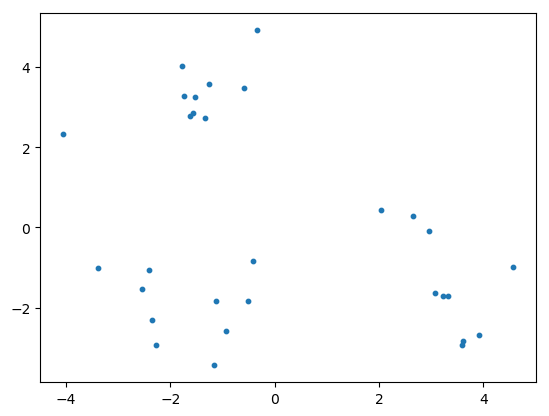

In [52]:
using PyPlot
theta = kron([0 0; 5 0; 0 5],ones(10))
srand(2)
y = theta + randn(30,2);
y = y .- mean(y,1)
c = repeat(["darkred";"darkblue";"darkgreen"],inner = (10,1));
scatter(y[:,1],y[:,2], s = 10);

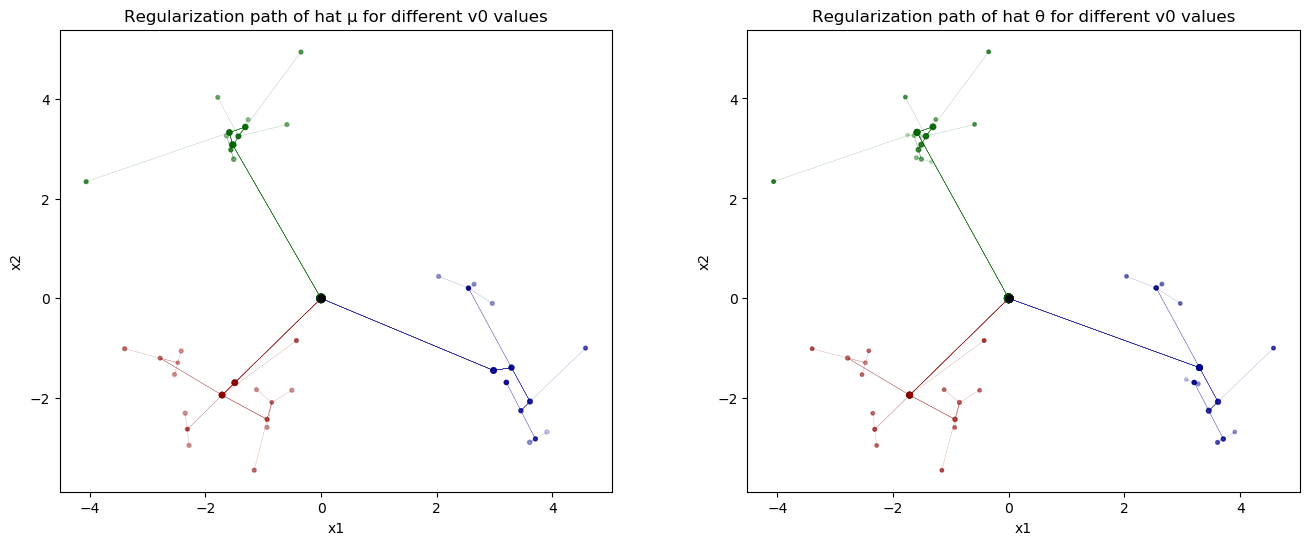

In [72]:
fig, axs = subplots(2, 3, figsize = (16, 6))
############################################################
v0_range = 0.001 * 3.^(1:10); subset = 1:10; s = length(v0_range);
t = zeros(s,2,30);
res = zeros(s,2,30);
siz = zeros(s,30);
for i = 1:s
    out = BGSM_clust(y, v0 = v0_range[i], iter = 1000)
    for j = 1:30
        res[i,:,j] = out[:mu][j,:]
        t[i,:,j] = out[:theta_tilde][j,:]
        siz[i,j] = sum(out[:R],2)[j];
    end
end
############################################################
subplot2grid((20,20), (0,11), rowspan = 20, colspan = 10)
############################################################
for j = 1:30
    #plot(t[subset,1,j],t[subset,2,j],"-o", color = c[j], linewidth=0.5, alpha = 0.1, ms = 5)
    scatter(t[subset,1,j],t[subset,2,j], marker = "o", color = c[j],
        s = (siz[:,j] + 5), alpha = 0.2);
    plot(t[subset,1,j],t[subset,2,j], "-", color = c[j],
        linewidth=0.1)
end
plot(0,0, color = "black", "o", ms = 5)
xlabel("x1"); ylabel("x2")
title("Regularization path of hat θ for different v0 values")

############################################################
subplot2grid((20,20), (0,0), rowspan = 20, colspan = 9)
############################################################
res[1,:,:] = 0; siz[1,:] = 4;
subset = 2:10
for j = 1:30
    scatter(res[subset,1,j],res[subset,2,j], marker = "o", color = c[j],
        s = (siz[:,j] + 5), alpha = 0.2);
    plot(res[subset,1,j],res[subset,2,j], "-", color = c[j],
        linewidth=0.1)
end
plot(0,0, color = "black", "o", ms = 5)
xlabel("x1"); ylabel("x2")
title("Regularization path of hat μ for different v0 values")
############################################################

savefig("figure/F2.pdf")